In [13]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models


import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
from schemes.avalanche_scheme import avalanche_model, get_slope         	

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 5.3

In this section we revisit the simple morphyodynamic model which eliminates the shallow water solved and focuses on just the convection of the the dunes.

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

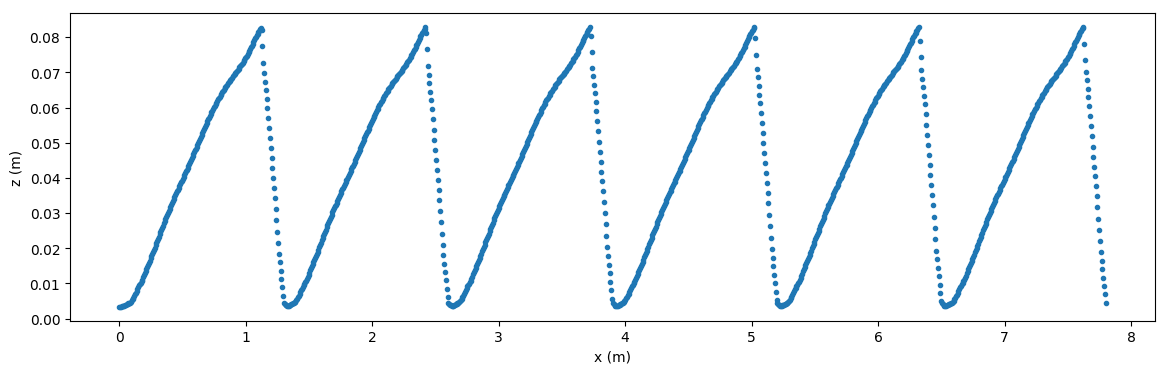

In [14]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [15]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# Water Surface Elevation
sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------

simTime = 300*60       # Runtime in seconds
dt = 0.10             # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 32 cm Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]

$
q_{sb} = \frac{z}{\Delta}q_{sb}^{max}
$

This equation basically says that the bed load is equal to the local local elevation multiplied by the peak bedload. the $q_{sb}^{max}$ is calibrated to match the migration rate of the dune.

 Starting simulation....
Number of time steps: 3000.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.0428652648316391
Courant number: max 0.006607601698599016, mean0.006607539175932614
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.042865264831639084
Courant number: max 0.006607601698582861, mean0.006606604338204147
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.042865264831639084
Courant number: max 0.006607601698582869, mean0.006606280446882705
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.042865264831639084
Courant number: max 0.006607601698583039, mean0.006606495872104013
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526483163908
Courant number: max 0.006607601698584171, mean0.006607037570526925
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483163908
Courant number: max 0.00

Text(0, 0.5, 'z (m)')

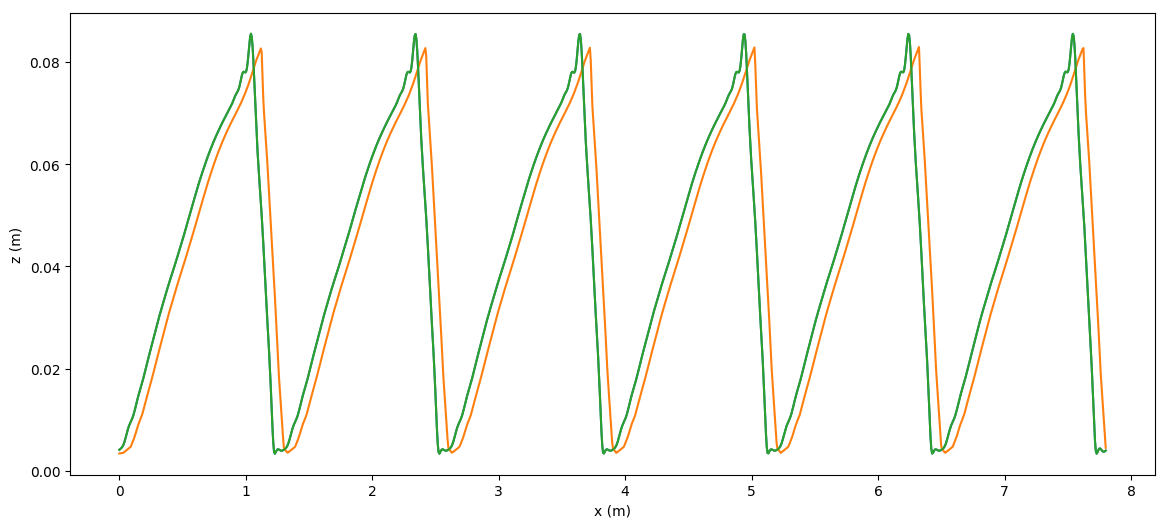

In [20]:
model = parameter_models.ParameterizedMorphologicalModel()

dt = 0.5   

run_name = 'Section_5.3.dune_5_EulerWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy'

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = exner_models.EulerWenoModel()
#morph_model = exner_models.TV
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h


df = model.get_wave_dataframe()
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

 Starting simulation....
Number of time steps: 300.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483161898
Courant number: max 0.0660760169858292, mean0.06606956243307523
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.04286526483161899
Courant number: max 0.06607601698582864, mean0.06607601698582703
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483161899
Courant number: max 0.06607601698586703, mean0.06607496345271689
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526483161899
Courant number: max 0.06607601698582857, mean0.06606913442046002
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526483161899
Courant number: max 0.06607601698584288, mean0.0660673134353065
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483161899
Courant number: max 0.06607601698582956

Text(0, 0.5, 'z (m)')

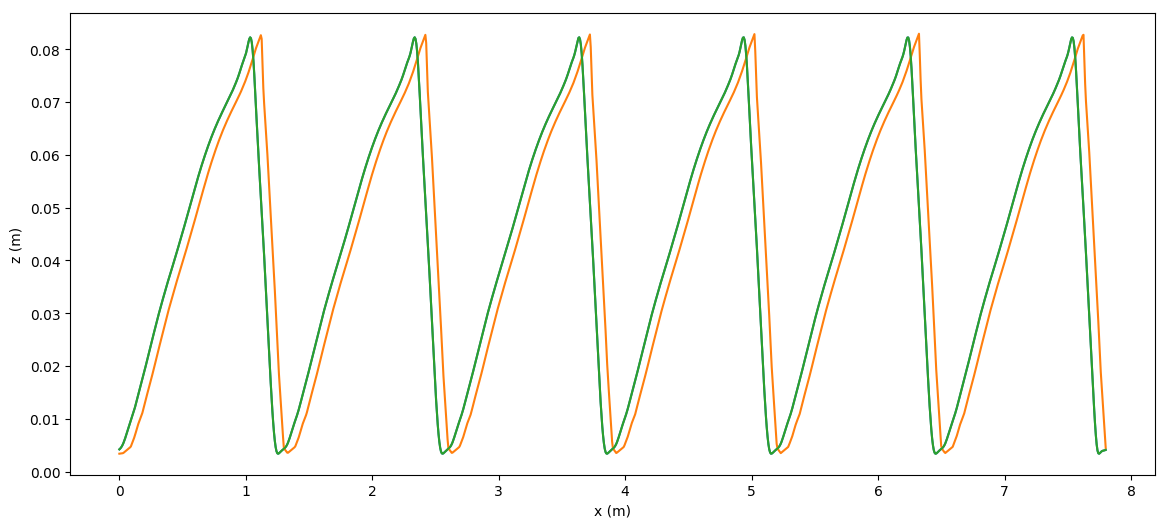

In [17]:
model = parameter_models.ParameterizedMorphologicalModel()

run_name = 'Section_5.3.dune_5_TvdWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy'

# !!!!!!!!!!!!!!!!!!!!!!!
dt = 1.0 

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = exner_models.TVD2ndWenoModel()
#morph_model = exner_models.TV
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h


df = model.get_wave_dataframe()
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [28]:
#--------------------------------
#  Initialize the model
#--------------------------------

run_name = 'Section_5.3.dune_5_EulerWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)

# !!!!!!!!!!!!!!!!!!!!!!!
dt = 0.5
#-------------------------
# Set the bedload formula
#-------------------------

#qsbmax = 0.000020375
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.EulerWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)


%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)

Initalized
 Starting simulation....
Number of time steps: 600.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483162995
Courant number: max 0.03782878303343676, mean0.020563365009712977
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.04286526483087528
Courant number: max 0.034854135320712555, mean0.02069920462987819
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483001474
Courant number: max 0.03274507502354604, mean0.020877688725184307
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.042865264829857516
Courant number: max 0.031164268678776898, mean0.02104698064797796
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526482992156
Courant number: max 0.029893568670922136, mean0.0211920186046293
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526482968573
Courant number: max 0

Text(0, 0.5, 'z (m)')

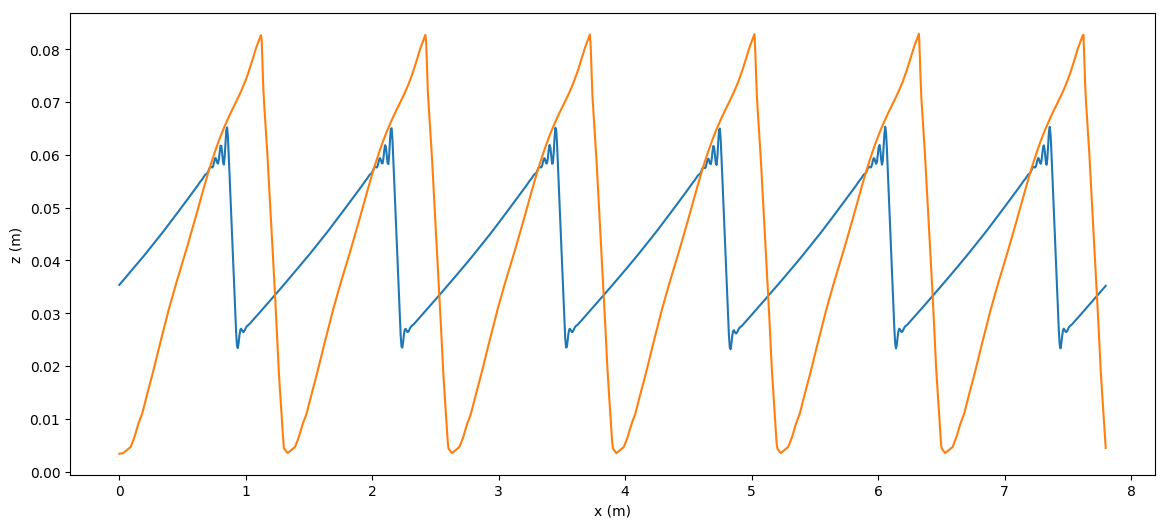

In [29]:


df = model.get_wave_dataframe()
verts = model._verts


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [30]:
#--------------------------------
#  Initialize the model
#--------------------------------

run_name = 'Section_5.3.dune_5_TvdWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#-------------------------
# Set the bedload formula
#-------------------------
#qsbmax = 0.000020375
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)


%time xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)

Initalized
 Starting simulation....
Number of time steps: 600.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.0428652648311367
Courant number: max 0.03775314289563923, mean0.02056237394290829
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.0428652648305108
Courant number: max 0.034804225908726234, mean0.020699834697010193
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483023583
Courant number: max 0.032736226326633554, mean0.020877651178652114
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526482974539
Courant number: max 0.031157861603338475, mean0.021047372684827342
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.042865264829847774
Courant number: max 0.029890546078568395, mean0.021191997779684234
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526482899736
Courant number: max

Text(0, 0.5, 'z (m)')

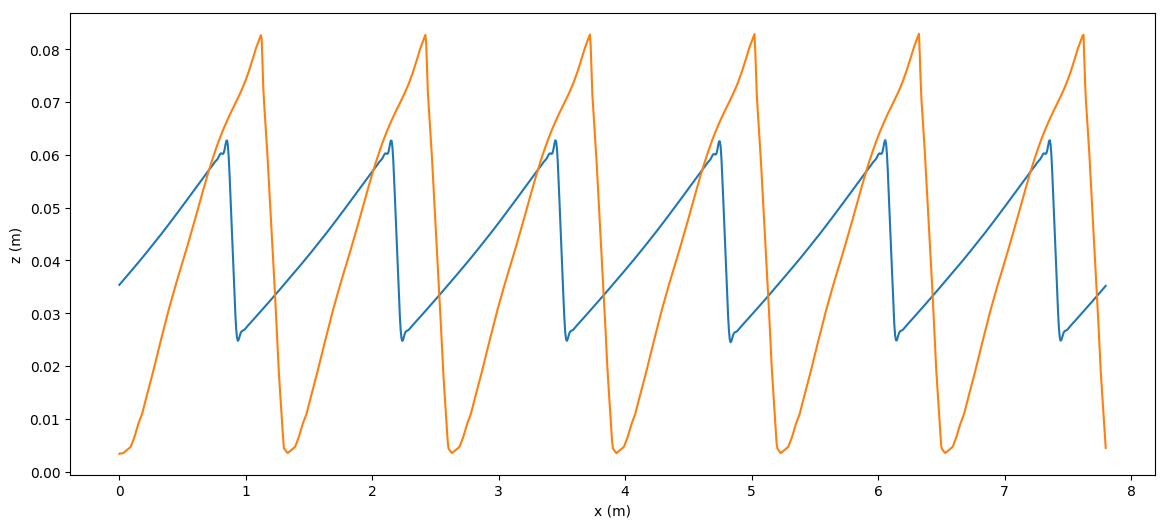

In [31]:
df = model.get_wave_dataframe()
verts = model._verts


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')